<h1>Fundamentals of Convolutional Layers, Pooling Techniques, and Basic Image Classification</h1>

<h2>Convolutional Layers</h2>
A convolutional layer is the building block of a Convolutional Neural Network (CNN). It works by applying a filter (or kernel) over an input image to extract important features, such as edges, corners, or textures.

Concept: A filter slides over the image, and at each step, it performs an element-wise multiplication between the filter values and the corresponding image region. The results are summed up to produce a single output value. This operation is repeated for the entire image, creating a new "feature map" that highlights specific patterns.

Purpose: The convolution operation helps detect spatial hierarchies in images. For example, the first layer might detect edges, while deeper layers detect complex structures like faces or objects.
In the manual implementation, we created a helper function convolve2d() to demonstrate this operation step-by-step using an example image and a kernel.



In [13]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt

# Helper function for creating 2D convolutions manually
def convolve2d(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    output_height = h - kh + 1
    output_width = w - kw + 1

    convolved_image = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            
            convolved_image[i, j] = np.sum(image[i:i+kh, j:j+kw] * kernel)
            
            # Another method utilising dot product
            # Extract the region of the image corresponding to the kernel size
            region_flat = image[i:i+kh, j:j+kw].reshape(-1)
            kernel_flat = kernel.reshape(-1)   
            # Perform dot product between flattened region and kernel
            convolved_image[i, j] = np.dot(region_flat, kernel_flat)

    return convolved_image

<h2>Pooling Techniques</h2>

Pooling layers are used to reduce the spatial dimensions of feature maps while retaining their important features. This simplifies computations and reduces overfitting by discarding unnecessary details.

<h3>Max Pooling</h3>
Takes the maximum value from each region of the feature map. This helps retain the most prominent features and makes the model more robust to minor image variations (e.g., noise).

<h3>Average Pooling</h3>
Computes the average value in each region. While less common in modern architectures, it can smooth the feature maps.

In [14]:
def pooling2d(image, pool_size, stride, mode):
    h, w = image.shape
    ph, pw = pool_size
    output_height = (h - ph) // stride + 1
    output_width = (w - pw) // stride + 1

    pooled_image = np.zeros((output_height, output_width))

    for i in range(0, h - ph + 1, stride):
        for j in range(0, w - pw + 1, stride):
            region = image[i:i+ph, j:j+pw]
            if mode == 'max':
                pooled_image[i // stride, j // stride] = np.max(region)
            elif mode == 'avg':
                pooled_image[i // stride, j // stride] = np.mean(region)
    return pooled_image

<h2>Basic Image Classification Using PyTorch</h2>

<h3>Building a Simple CNN</h3>
<b>Structure of typical Convolutional Neural Network (CNN)</b>
<br>Convolutional Layer: Extracts features from input images using filters.</br>
ReLU Activation: Introduces non-linearity to allow the network to learn complex patterns.
<br>Pooling Layer: Reduces the spatial size of feature maps and focuses on prominent features.</br>
Fully Connected Layer: Maps the learned features to the desired output (e.g., classification into categories).

<h3>Training a Model</h3>
<b>Training involves the following steps:</b>
<br>Forward Pass: Input images pass through the model to generate predictions.</br>
Loss Computation: The loss function (Cross-Entropy Loss) evaluates how far predictions are from the true labels.
<br>Backward Pass: Gradients of the loss with respect to the model parameters are computed using backpropagation.</br>
Parameter Update: The optimizer (SGD) updates the model parameters to minimize the loss.

<br>The following is a basic example using the MNIST dataset.</br>

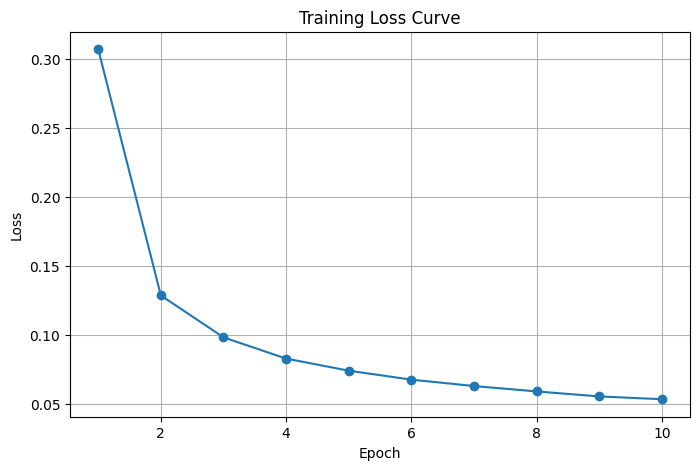

Test Accuracy: 98.09%


In [15]:
# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defining a simple CNN for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(8 * 13 * 13, 10)  # Assuming input image size is 28x28

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(torch.relu(x))
        x = x.view(-1, 8 * 13 * 13)
        x = self.fc(x)
        return x

# Preparing dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
data_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

data_loader_train = DataLoader(data_train, batch_size=16, shuffle=True)
data_loader_test = DataLoader(data_test, batch_size=16, shuffle=False)

# Initializing the CNN model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10  # Set the number of epochs
loss_values = []  # List to store loss values

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(data_loader_train, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    
    loss_values.append(epoch_loss / len(data_loader_train))  # Store average loss per epoch

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

# Evaluation loop
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

accuracy = evaluate_model(model, data_loader_test)
print(f"Test Accuracy: {accuracy:.2f}%")
